# 1. Preprocessing

First we import all the libraries we will need in order to load and preprocess the data. 

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

We import the csv file:

In [2]:
zip_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip", 
    fname='jena_climate_2009_2016.csv.zip', 
    extract=True
    )

csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
df.shape

(420551, 15)

**We have 10 minutes intervals. There is no need to have that much data. Let's take every hour invertvals.**

In [5]:
df_short = df[5::6].reset_index(drop=True)
df_short.shape

(70091, 15)

In [6]:
df_short.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
5,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
6,01.01.2009 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
7,01.01.2009 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
8,01.01.2009 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2
9,01.01.2009 10:00:00,1000.27,-7.04,266.10,-8.17,91.6,3.60,3.30,0.30,2.05,3.29,1307.76,1.45,3.00,292.6


The forecasting we are going to try to predict will be with the temperature, although you can do it with any variable you want, such as pressure or wind. 

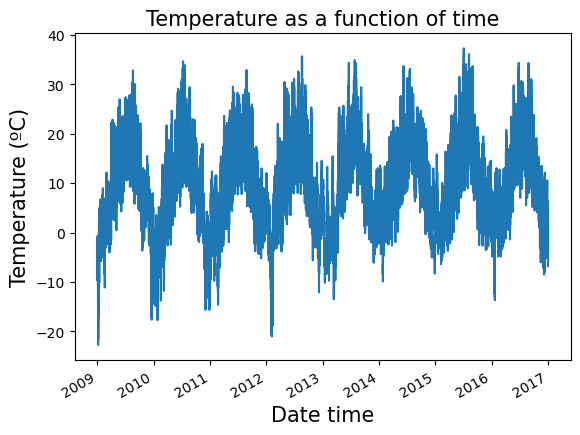

In [7]:
df_short.index = pd.to_datetime(df_short['Date Time'], format='%d.%m.%Y %H:%M:%S')
temperature = df_short['T (degC)']

plt.title('Temperature as a function of time', fontsize=15)
temperature.plot()

plt.xlabel('Date time', fontsize=15)
plt.ylabel('Temperature (ºC)', fontsize=15)
plt.show()

## 2. Model architecture

The model we are going to implement is an LSTM many-to-one. Using some temperatures of the past, we will try to predict the temperature at the next given state. In order to do that, we need to create a dataset with the next format: 

* Input: [T(0), T(1), T(2), T(3), ..., T(N)]
* Target: [T(N+1]

The function down below will also have the option to create a many-to-many prediction:

* Input: [T(0), T(1), T(2), T(3), ..., T(N)]
* Target: [T(1), T(2), T(3), ..., T(N), T(N+1)]

In [8]:
def inputs_targets(dataframe, past_size, many_to_one=True):
    """
    dataframe: pd.Dataframe
               - Contains the variable we want to forecast
    past_size: int
               - How much into the past are we going to look 
                 in order to predict
                 
    many_to_one: bool
               - If True, the dataset will be created to 
                 implement a many-to-one architecture, if False
                 it will be created to implement a many-to-many 
                 architecture
    """
    array = dataframe.to_numpy()
    inputs, targets = [], []
    
    for i in range(len(array) - past_size):
        inputs.append([[value] for value in array[i: i + past_size]])
        if many_to_one:
            targets.append([array[i + past_size]])
        else:
            targets.append([[target] for target in array[i + 1: i + past_size + 1]])
        
    inputs = np.array(inputs)
    targets = np.array(targets)
    return inputs, targets

### 2.1 Parameters of the model

Since we are trying to predict the temperature, we need to use as a **Cost** function the `Mean Squared Error` and as an output function a `Linear` function. 

The past information we will use is governed by the parameter `PAST_SIZE`. 

In [9]:
from LSTMClass import LSTM

def mse(y_pred, y):
    return np.mean((y_pred - y) ** 2)

def grad_mse(y_pred, y):
    return y_pred - y

def linear(z):
    return z

def deriv_linear(z):
    return 1


# past information 
PAST_SIZE = 5

# input units: PAST_SIZE
input_units = PAST_SIZE

# output units: 1 --> many-to-one architecture
output_units = 1

# number of hidden units
hidden_units = 50

# learning_rate
learning_rate = 1e-3

lstm = LSTM(hidden_units=hidden_units, input_units=input_units, 
            loss=mse, grad_loss=grad_mse, output_units=output_units, 
            learning_rate=learning_rate, output_activation=linear, max_norm=1.0)

Here we select the training set size, validation set size and test set size. 

In [10]:
if output_units > 1:
    many_to_one = False
else:
    many_to_one = True

# create the data set in the correct format
X, y = inputs_targets(temperature, PAST_SIZE, many_to_one=many_to_one)

print('Data shape: ')
print(X.shape, y.shape)

train_samples = 60_000
val_samples = 5_000
test_samples = len(X) - train_samples - val_samples

X_train, y_train = X[:train_samples], y[:train_samples]
X_val, y_val = X[train_samples: train_samples + val_samples], y[train_samples: train_samples + val_samples]
X_test, y_test = X[-test_samples:], y[-test_samples:]

print('Training shape, validation shape and test shape: ')
print(X_train.shape, X_val.shape, X_test.shape)

Data shape: 
(70086, 5, 1) (70086, 1)
Training shape, validation shape and test shape: 
(60000, 5, 1) (5000, 5, 1) (5086, 5, 1)


# 3. Train the model 

The function down below will train the model:

In [11]:
def train(model, inputs, targets, epochs=100, 
          max_samples=10_000):
    """
    model: LSTM 
            - The LSTM object to fit the data
    inputs: array-like. 
            - This array contains the training inputs values. 
    targets: array-like
            - Target of the inputs: label 
    epochs: int
            - Number of times to go through the dataset
    max_samples: int
            - If the training set is too large, with this 
              parameter we will control how many samples 
              of the trainig set to use in order to 
              fit the model
    """
    
    cost = []
    
    for epoch in range(epochs):
        
        loss = 0
        
        for input_t, target_t in zip(inputs[:max_samples], targets[:max_samples]):
            model.forward([input_t])
            model.backward([target_t])
            model.optimize()
            loss += model.loss_pass
            
        cost.append(loss / len(inputs[:max_samples]))
        
        if not (epoch + 1) % (epochs // 10):
            print(f'Loss in epoch {epoch + 1}th: ', np.round(loss / len(inputs[:max_samples]), 
                                                         decimals=3))
            
    fig, ax = plt.subplots()
    ax.scatter(range(1, epochs + 1), cost, c='blue', edgecolor='black', 
               s=50, alpha=0.8)
    ax.set_xlabel('Epochs', fontsize=20)
    ax.set_ylabel('Cost', fontsize=20)
    
    plt.show()
    
    return model

**Training the model:**

* **Epochs:** 30
* **Max samples:** 30 000

Loss in epoch 3th:  3.685
Loss in epoch 6th:  2.049
Loss in epoch 9th:  1.558
Loss in epoch 12th:  1.324
Loss in epoch 15th:  1.189
Loss in epoch 18th:  1.095
Loss in epoch 21th:  1.028
Loss in epoch 24th:  0.978
Loss in epoch 27th:  0.941
Loss in epoch 30th:  0.91


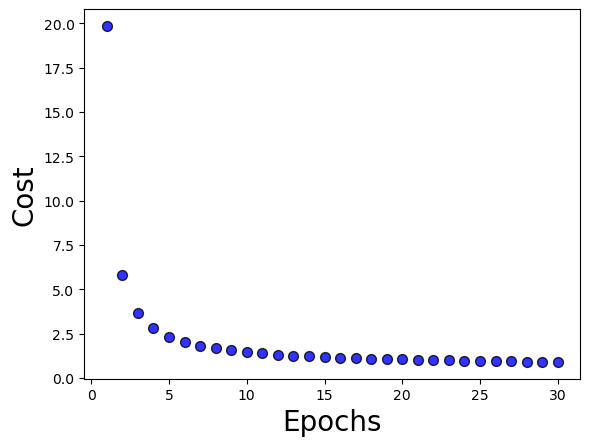

In [12]:
lstm = train(lstm, X_train, y_train, epochs=30, max_samples=30_000)

# 4. Show results

In [13]:
def show_results(model, input_dataset, range_to_plot, 
                 dataframe):
    
    """
    model: LSTM Class. 
           - Trained model in order to make predictions 
             with the different datasets
    input_dataset: str
           - Set we are trying to make predictions of. 
             It must be one of: ['training', 'validation', 'test']
    range_to_plot: tuple
           - Range of the data set to make predictions
    dataframe: pd.Series
           - Feature we are trying to predict. In this notebook: temperature
    """
    global X_train, X_val, X_test, PAST_SIZE
    datasets = {'training': X_train, 'validation': X_val, 'test': X_test}
    assert input_dataset in datasets
    
    X_train = datasets['training']
    X_val = datasets['validation']
    
    begin, end = range_to_plot
    inputs = datasets[input_dataset][begin: end]
    
    predictions = []
    
    range_plots = {'training': 0, 
                   'validation': len(X_train), 
                   'test': len(X_train) + len(X_val)}
    
    df_begin= range_plots[input_dataset]
    df_begin += begin
    df_end = df_begin + end
    
    for x_t in inputs:
        model.forward([x_t])
        predict = [outputs[1].flatten()[0] for outputs in model.outputs.items()]
        predictions.append(predict)
    
    fig, ax = plt.subplots()
    ax.plot(dataframe[df_begin: df_end], c='blue', label='Real')
    ax.plot(dataframe.index[PAST_SIZE + df_begin: PAST_SIZE + df_end], predictions, 
            c='red', alpha=0.5, label='Prediction')
    
    ax.legend()
        
    plt.show()

## 4.1 Training set

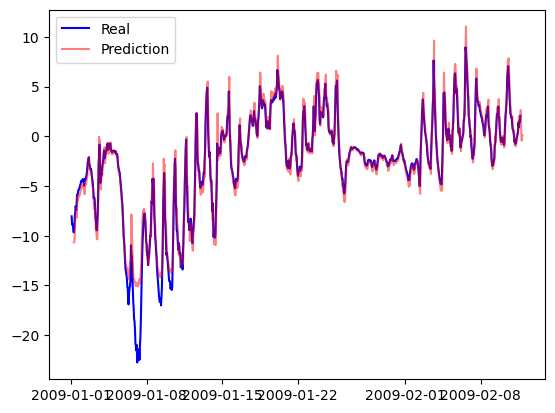

In [14]:
show_results(lstm, 'training', (0, 1000), temperature)

## 4.2 Validation set

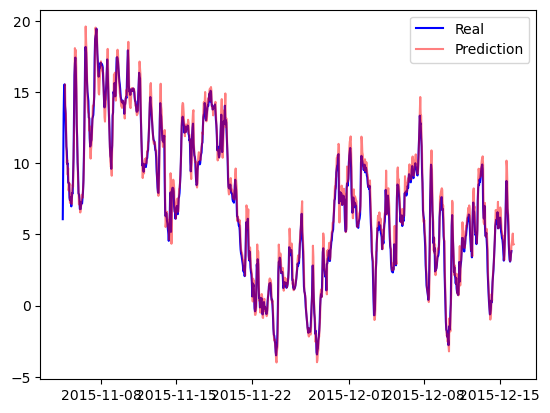

In [15]:
show_results(lstm, 'validation', (0, 1000), temperature)

## 4.3 Test set

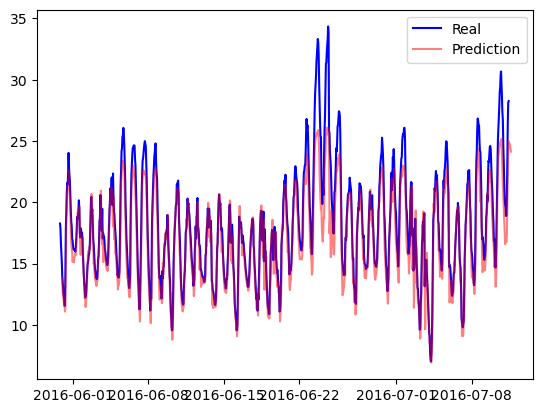

In [16]:
show_results(lstm, 'test', (0, 1000), temperature)

# 5. TensorFlow model

## 5.1 Create model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD

model = Sequential()
model.add(InputLayer((PAST_SIZE, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


## 5.2 Fit the model

In [18]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), 
              optimizer=SGD(learning_rate=1e-4), 
              metrics=[RootMeanSquaredError()])

In [19]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), 
          epochs=10, callbacks=[cp])

Epoch 1/10


2022-12-06 13:05:18.561764: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1851/1875 [============================>.] - ETA: 0s - loss: 14.1135 - root_mean_squared_error: 3.7568

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 6s 3ms/step - loss: 13.9906 - root_mean_squared_error: 3.7404 - val_loss: 1.8603 - val_root_mean_squared_error: 1.3639
Epoch 2/10
1859/1875 [============================>.] - ETA: 0s - loss: 3.0897 - root_mean_squared_error: 1.7578

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 3.0889 - root_mean_squared_error: 1.7575 - val_loss: 1.1182 - val_root_mean_squared_error: 1.0575
Epoch 3/10
1853/1875 [============================>.] - ETA: 0s - loss: 1.8686 - root_mean_squared_error: 1.3670

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 1.8638 - root_mean_squared_error: 1.3652 - val_loss: 0.9422 - val_root_mean_squared_error: 0.9707
Epoch 4/10
1848/1875 [============================>.] - ETA: 0s - loss: 1.4815 - root_mean_squared_error: 1.2172

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 1.4830 - root_mean_squared_error: 1.2178 - val_loss: 0.8954 - val_root_mean_squared_error: 0.9462
Epoch 5/10
1853/1875 [============================>.] - ETA: 0s - loss: 1.2628 - root_mean_squared_error: 1.1238

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 1.2630 - root_mean_squared_error: 1.1238 - val_loss: 0.7520 - val_root_mean_squared_error: 0.8672
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.1202 - root_mean_squared_error: 1.0584 - val_loss: 0.7997 - val_root_mean_squared_error: 0.8942
Epoch 7/10
1846/1875 [============================>.] - ETA: 0s - loss: 1.0326 - root_mean_squared_error: 1.0162

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 1.0309 - root_mean_squared_error: 1.0153 - val_loss: 0.7077 - val_root_mean_squared_error: 0.8412
Epoch 8/10
1853/1875 [============================>.] - ETA: 0s - loss: 0.9725 - root_mean_squared_error: 0.9862

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.9700 - root_mean_squared_error: 0.9849 - val_loss: 0.6652 - val_root_mean_squared_error: 0.8156
Epoch 9/10
1854/1875 [============================>.] - ETA: 0s - loss: 0.9263 - root_mean_squared_error: 0.9625

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.9276 - root_mean_squared_error: 0.9631 - val_loss: 0.6536 - val_root_mean_squared_error: 0.8085
Epoch 10/10
1845/1875 [============================>.] - ETA: 0s - loss: 0.8978 - root_mean_squared_error: 0.9475

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.8983 - root_mean_squared_error: 0.9478 - val_loss: 0.6394 - val_root_mean_squared_error: 0.7996


## 5.3 Loading the best model

In [20]:
from tensorflow.keras.models import load_model

best_model = load_model('model/')

## 5.4 Show Tensorflow results

In [21]:
def plot_tensorflow_results(X, y, dataframe, model, range_to_plot):
    """
    X: array-like
       - Dataset from which make predictions. 
         It can be: training, validation or test set
         
    y: array-like
       - Labels/Targets of X
       
    dataframe: pd.Series
       - Dataframe we want to model
       
    range_to_plot: tuple
       - Show the range

    """
    begin, end = range_to_plot
    
    predictions = model.predict(X).flatten()
    results = pd.DataFrame(data={'Predictions': predictions, 
                                 'Real values': y.ravel()})
    
    plt.plot(dataframe.index[begin: end], 
             results['Real values'][begin: end], c='blue',label='Real Values')
    
    plt.plot(dataframe.index[begin: end], 
             results['Predictions'][begin: end], c='red', alpha=0.5, label='Predictions')
    plt.legend()
    
    plt.show()

### 5.4.1 Training set

1875/1875 [==============================] - 1s 482us/step


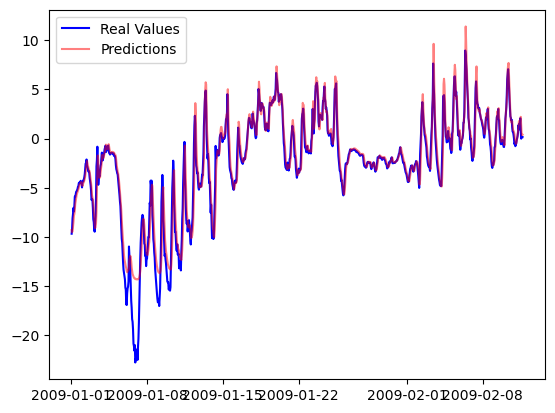

In [22]:
plot_tensorflow_results(X_train, y_train, temperature, model, (0, 1000))

### 5.4.2 Validation set

157/157 [==============================] - 0s 536us/step


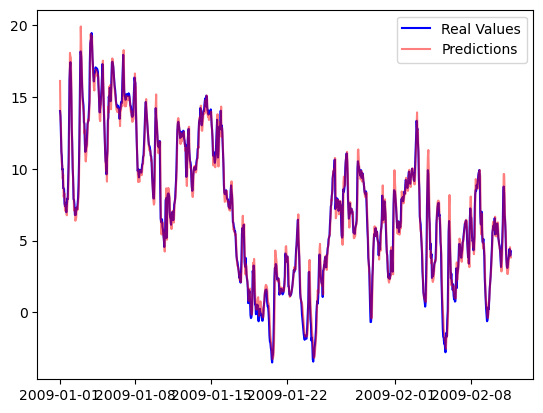

In [23]:
plot_tensorflow_results(X_val, y_val, temperature, model, (0, 1000))

### 5.4.3 Test set

159/159 [==============================] - 0s 519us/step


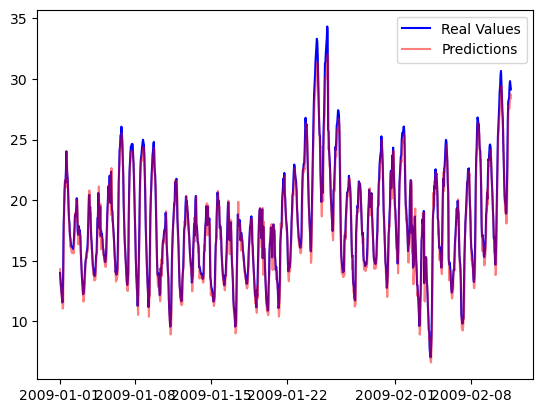

In [24]:
plot_tensorflow_results(X_test, y_test, temperature, model, (0, 1000))

## 6. Comparison between models

In [25]:
def comparison_plot(lstm_model, tf_model, input_dataset, range_to_plot, 
                    dataframe):
    
    """
    lstm_model: LSTM Class. 
           - Trained model in order to make predictions 
             with the different datasets
    tf_model: tf.Sequential 
           - TensorFlow trained model
    input_dataset: str
           - Set we are trying to make predictions of. 
             It must be one of: ['training', 'validation', 'test']
    range_to_plot: tuple
           - Range of the data set to make predictions
    dataframe: pd.Series
           - Feature we are trying to predict. In this notebook: temperature
    """
    global X_train, X_val, X_test, PAST_SIZE
    datasets = {'training': X_train, 'validation': X_val, 'test': X_test}
    assert input_dataset in datasets
    
    X_train = datasets['training']
    X_val = datasets['validation']
    
    begin, end = range_to_plot
    inputs = datasets[input_dataset][begin: end]
    
    range_plots = {'training': 0, 
                   'validation': len(X_train), 
                   'test': len(X_train) + len(X_val)}
    
    df_begin= range_plots[input_dataset]
    df_begin += begin
    df_end = df_begin + (end - begin)
    
    # scratch implementation predictions
    predictions = []
    for x_t in inputs:
        lstm_model.forward([x_t])
        predict = [outputs[1].flatten()[0] for outputs in lstm_model.outputs.items()]
        predictions.append(predict)
        
    # tensorflow predictions
    predictions_tf = tf_model.predict(inputs).flatten()
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    ax.set_title('Comparison between models', fontsize=15)
    
    ax.plot(dataframe[df_begin: df_end], c='blue', 
            ls='--', alpha=0.5, label='Real Values', lw=4)
    ax.plot(dataframe.index[PAST_SIZE + df_begin: PAST_SIZE + df_end], predictions, 
            c='red', label='Scratch implementation model')
    
    ax.plot(dataframe.index[df_begin + PAST_SIZE: df_end + PAST_SIZE], 
            predictions_tf, c='green', label='TensorFlow model')
    
    ax.legend()
    
    plt.show()

## 6.1 Training set

32/32 [==============================] - 0s 644us/step


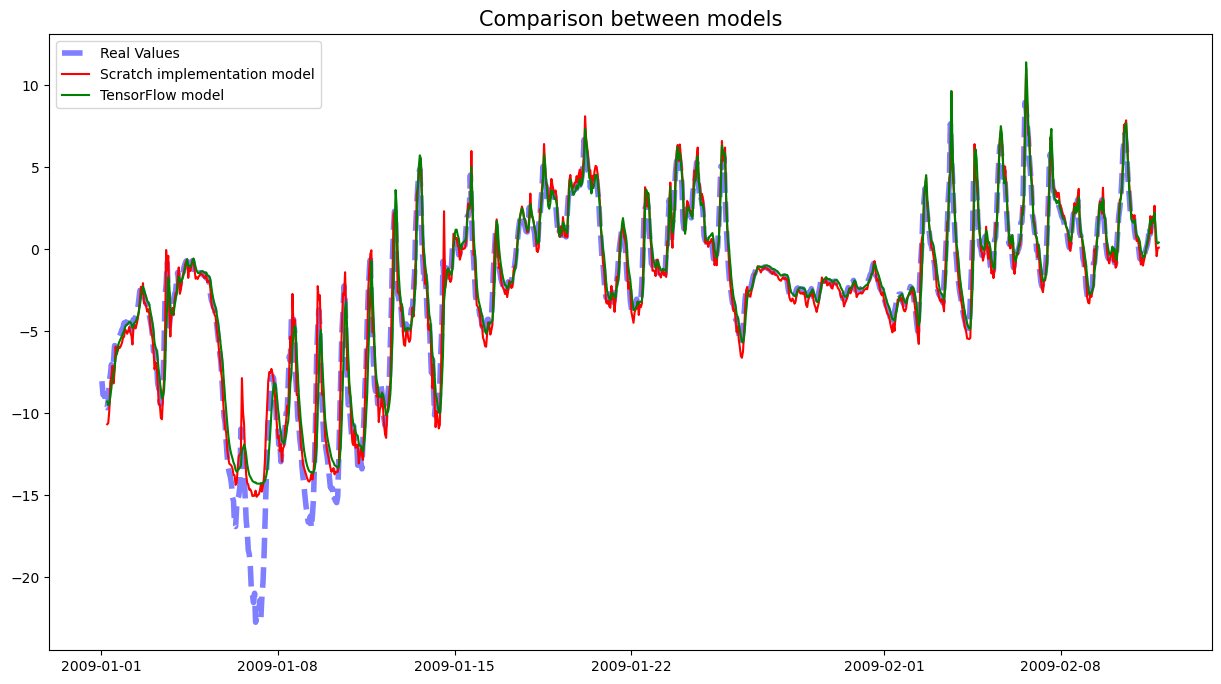

In [26]:
comparison_plot(lstm, best_model, 'training', (0, 1000), temperature)

## 6.2 Validation set

16/16 [==============================] - 0s 607us/step


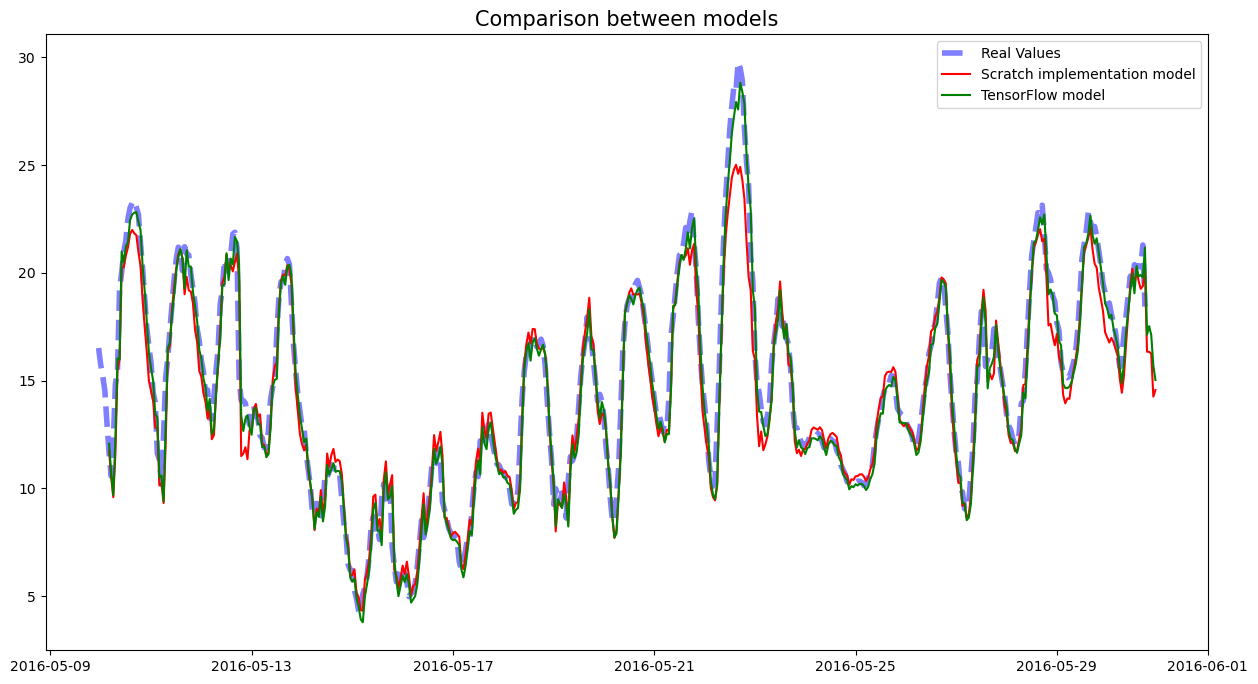

In [27]:
comparison_plot(lstm, best_model, 'validation', (4500, 5000), temperature)

## 6.3 Test set

66/66 [==============================] - 0s 570us/step


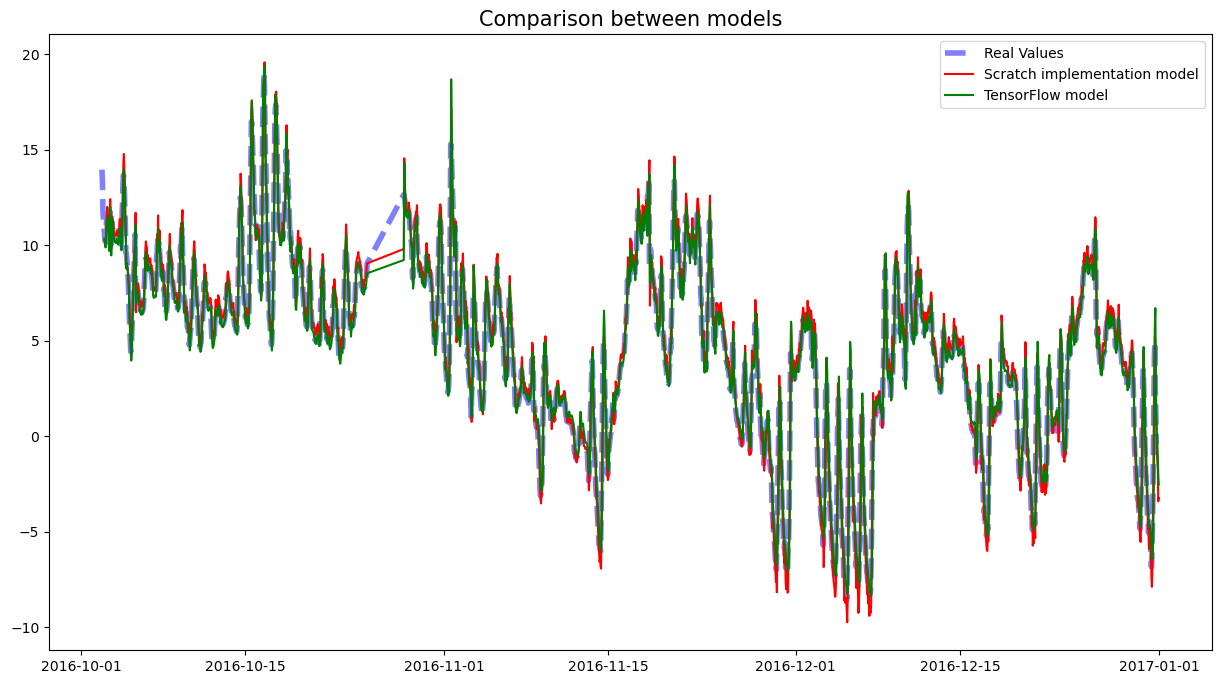

In [28]:
comparison_plot(lstm, best_model, 'test', (3_000, 5_086), temperature)

# 7. Comments

**Scratch implementation**

Looking at all the images we can see that the scratch implementation model performs really really well in the range of mid low (-15ºC - 0ºC) - mid high (0ºC - 25ºC) temperatures. It fails at predicting the temperature when it goes above 25-27 ºC and when it goes below -15ºC. 

`What can we do to improve this result?` We could do the same as with the TensorFlow model: 

* Try out various models and keep the one that performs better on the validation set. 
* Another idea would be to implement a better optimize algorihtm such as Adam, rms-prop or Batch Normalization. 
* Finally, add two Dense layers: relu and linear. 

**TensorFlow model**

The main difference respect our own implementation is the fact that the TF model predicts really well  high (0ºC - 35ºC) temperatures, altought it fails to predict in the low range: -10ºC to -30ºC. 

# 8. Conclusions

In this particular case of predicting the temperature, we could use our own implementation to predict the temperature in the mid low - mid high temperatures with high precision, but, in the high temperature range we would probably have to use the TF model. For the low range neither of them performs pretty well. 

Looking at the figures we can see that the TF model and our model are very similar, overlapping practically everywhere. Therefore we can say without a doubt that our model works, meaning that the implementation has been done correctly and we can use this implementation in many other tasks knowing that the results will be very satisfactory. 